# Project Overview
In this project, we will be predicting the sales of a supermarket chain (Rossman) using a number of inputs like day, month, whether there is a promotion and so on. The project can be divided into **4 parts**:
### Part 1 - Data preprocessing
   We first explore the data to handle missing samples and represent the features in a format that is more suitable for training a deep neural network or a regression tree.
### Part 2 - Visual Exploratory Data Analysis (EDA)
   After presenting the data in a more suitable format, we analyze the relation between our features visually using graphs for example to decide which features are relevant for making an estimate of Sales.
### Part 3 - Statistical EDA
   Some features are difficult to visualize, therefore, we use statistical methods to help determine their relevance for the estimation of Sales.
### Part 4 - Deep Neural Network (DNN)
   In this part we train a deep neural network using the features that we settled with and assess its performance on a validation set.   
### Part 5 - Regression forest
The DNN may perform poorly in general since some samples (holidays for example) are under-represented in the training data since there are simply fewer holidays than normal days, this would lead to worse performance. To solve that, we use a regression forest which trains a series of regression trees, where each tree is trained subsequently with more emphasis on the samples that were difficult for the earlier regression tree. This would result in an improved performance compared to the DNN.

In [1]:
#Before starting we import all the packages we may need
import pandas as pd
from scipy.stats import alpha, f_oneway
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn
import sklearn.model_selection
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import sklearn
import sklearn.model_selection

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import joblib

# Importing the Data
Here, we directly read the csv file. In my personal PC however, MySQL was used for data storage and for importing it later on.

In [2]:
train_df = pd.read_csv("./Datasets/train.csv", low_memory=False)
store_df = pd.read_csv("./Datasets/store.csv", low_memory=False)

# Adjust pandas display settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

#Show first 5 samples of each dataframe
display(store_df.head(5))
display(train_df.head(5))

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Both **store_df** and **train_df** make up our **training set**. We can see that in train_df, there is a feature named Store, this means that for each Store, there is additional data related to it stored within store_df.

We **merge both dataframes** by store number since Store information will probably be relevant for making Sales estimates.

In [3]:
merged_train_df = pd.merge(train_df, store_df, on="Store")
display(merged_train_df.head(5))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Part 1 - Data Preprocessing

Briefly check if missing values exist.

In [4]:
display(merged_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

None

Since some features have fewer samples, this means that we do have missing values.

The columns **(CompetitionOpenSinceMonth,CompetitionOpenSinceYear)** can be reduced to a single column of **(CompetitionOpenSinceDate)**. Reducing the number of dimensions

In [5]:
competitionDate_df = (merged_train_df[['CompetitionOpenSinceYear',
                                             'CompetitionOpenSinceMonth']]
                          .rename(columns={'CompetitionOpenSinceYear': 'YEAR',
                                           'CompetitionOpenSinceMonth': 'MONTH'}))
competitionDate_df = pd.to_datetime(competitionDate_df[['YEAR', 'MONTH']].assign(DAY=1))
merged_train_df['CompetitionOpenSinceYear'] = competitionDate_df
merged_train_df.drop('CompetitionOpenSinceMonth', axis=1, inplace=True)
merged_train_df.rename(columns={'CompetitionOpenSinceYear': 'CompetitionOpenSinceDate'}, inplace=True)
display(merged_train_df.head(5))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceDate,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,2008-09-01,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,2007-11-01,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,2006-12-01,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,2009-09-01,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,2015-04-01,0,NaN,NaN,NaN


Columns **(Promo2SinceWeek, Promo2SinceYear)** can be reduced to a single column of **(Promo2SinceDate)**. Reducing n_dimensions.

In [6]:
temp_df = pd.DataFrame(index=merged_train_df.index)
temp_df['Promo2SinceYear'] = merged_train_df['Promo2SinceYear'].fillna(1900)  # or choose another default year
temp_df['Promo2SinceWeek'] = merged_train_df['Promo2SinceWeek'].fillna(1).astype(int)
promo2sinceDate_df = pd.to_datetime(temp_df['Promo2SinceYear'].astype(str) + '101',format='%Y.%m%d')
promo2sinceDate_df += pd.to_timedelta(temp_df['Promo2SinceWeek'] - 1, unit='W')
merged_train_df['Promo2SinceYear'] = promo2sinceDate_df
merged_train_df.drop('Promo2SinceWeek', axis=1, inplace=True)
merged_train_df.rename(columns={'Promo2SinceYear': 'Promo2SinceDate'}, inplace=True)
merged_train_df.loc[merged_train_df['Promo2SinceDate'].dt.year == 1900, 'Promo2SinceDate'] = None
display(merged_train_df.head(5))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceDate,Promo2,Promo2SinceDate,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,2008-09-01,0,NaT,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,2007-11-01,1,2010-03-26,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,2006-12-01,1,2011-04-02,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,2009-09-01,0,NaT,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,2015-04-01,0,NaT,NaN


The Columns **CompetitionOpenSinceDate and Promo2SinceDate** can be made more useful by converting them to number of days from the current date in column Date under new names of **(CompetitionOpenForDays / Promo2ForDays)**

In [7]:
merged_train_df['Promo2SinceDate'] = pd.to_datetime(merged_train_df['Promo2SinceDate'])
merged_train_df['Date'] = pd.to_datetime(merged_train_df['Date'])
merged_train_df['Promo2SinceDate'] = merged_train_df['Date'] - merged_train_df['Promo2SinceDate']
merged_train_df.rename(columns={'Promo2SinceDate': 'Promo2ForDays'}, inplace=True)
merged_train_df['CompetitionOpenSinceDate'] = merged_train_df['Date'] - merged_train_df['CompetitionOpenSinceDate']
merged_train_df.rename(columns={'CompetitionOpenSinceDate': 'CompetitionOpenForDays'}, inplace=True)
merged_train_df["Promo2ForDays"] = merged_train_df["Promo2ForDays"].dt.days  # take n_days as integer NOT datetime
merged_train_df["CompetitionOpenForDays"] = merged_train_df["CompetitionOpenForDays"].dt.days  # take n_days as integer NOT datetime
display(merged_train_df.head(5))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenForDays,Promo2,Promo2ForDays,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,2524.0,0,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,2829.0,1,1953.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,3164.0,1,1581.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,2159.0,0,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,121.0,0,NaN,NaN


### Sanity Check!
Just to ensure what we have makes sense, we look for negative Day values

In [8]:
indices_negative_promo = merged_train_df.query('Promo2ForDays < 0').index
indices_negative_competition = merged_train_df.query('CompetitionOpenForDays < 0').index
indices_sample_negative_promo = sample(list(indices_negative_promo), 5)
indices_sample_negative_competition = sample(list(indices_negative_competition), 5)
display(merged_train_df.loc[indices_sample_negative_promo])
display(merged_train_df.loc[indices_sample_negative_competition])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenForDays,Promo2,Promo2ForDays,PromoInterval
1002450,851,1,2013-01-14,4287,403,1,0,0,0,d,c,2330.0,NaN,1,-688.0,"Mar,Jun,Sept,Dec"
869734,820,1,2013-05-13,16118,1383,1,1,0,0,a,c,1650.0,NaN,1,-506.0,"Jan,Apr,Jul,Oct"
824645,331,6,2013-06-22,3431,516,1,0,0,0,a,c,670.0,NaN,1,-649.0,"Jan,Apr,Jul,Oct"
994100,306,1,2013-01-21,4787,528,1,1,0,0,a,a,5100.0,2122.0,1,-618.0,"Jan,Apr,Jul,Oct"
663289,650,4,2013-11-14,4971,544,1,0,0,0,a,a,1420.0,409.0,1,-321.0,"Jan,Apr,Jul,Oct"


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenForDays,Promo2,Promo2ForDays,PromoInterval
965676,872,6,2013-02-16,7519,704,1,0,0,0,a,c,3860.0,-562.0,1,-838.0,"Mar,Jun,Sept,Dec"
301583,828,4,2014-10-23,5305,614,1,1,0,0,d,c,3290.0,-39.0,0,NaN,NaN
333471,944,5,2014-09-19,6963,1049,1,1,0,0,c,a,1670.0,-285.0,0,NaN,NaN
418591,137,6,2014-06-21,6531,740,1,0,0,0,a,a,1730.0,-375.0,1,-102.0,"Jan,Apr,Jul,Oct"
142944,225,3,2015-03-25,3708,438,1,0,0,0,d,a,10180.0,-37.0,0,NaN,NaN


We do have **negative values** in **Promo2ForDays and CompetitionOpenForDays** *because* their **date of occurrence is after the current Date**.

We handle each column separately since dealing with each means that the neighboring columns, namely CompetitionDistance and Promo2 will also have to be dealt with

#### Starting with CompetitionOpenForDays and CompetitionDistance

In [9]:
display("Neg CompetitionOpenForDays",len(list(merged_train_df.query('CompetitionOpenForDays < 0').index))/merged_train_df.shape[0])
display("Null CompetitionOpenForDays",merged_train_df["CompetitionOpenForDays"].isnull().sum()/merged_train_df.shape[0])
display("Null CompetitionDistance",merged_train_df["CompetitionDistance"].isnull().sum() / merged_train_df.shape[0])

'Neg CompetitionOpenForDays'

0.08323363241968956

'Null CompetitionOpenForDays'

np.float64(0.31787764363075827)

'Null CompetitionDistance'

np.float64(0.0025973030124586)

Almost **31 percent** of rows have **null CompetitionOpenForDays**, there is no reasonable way to impute these as they do NOT correlate with any other variable and attempting to impute is irrational.

Only 0.26 percent of the rows have null CompetitionDistance, these rows are dropped as they are too few
and imputation is not done for the same reason as before.

In [10]:
merged_train_df.drop('CompetitionOpenForDays', axis=1, inplace=True)
merged_train_df.dropna(subset=['CompetitionDistance'], inplace=True)

##### Moving on to Promo2 and Promo2ForDays

In [11]:
# First handling the negative values
merged_train_df.loc[merged_train_df["Promo2ForDays"] <= 0, "Promo2"] = 0
merged_train_df.loc[merged_train_df["Promo2"] == 0, "PromoInterval"] = '0'
merged_train_df.loc[merged_train_df["Promo2ForDays"] < 0, "Promo2ForDays"] = 0
# Then handling nan values
merged_train_df['Promo2ForDays'] = merged_train_df["Promo2ForDays"].fillna(0)
merged_train_df['PromoInterval'] = merged_train_df[['PromoInterval']].fillna('0')
print(merged_train_df.info())
display(merged_train_df.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 1014567 entries, 0 to 1017208
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   Store                1014567 non-null  int64         
 1   DayOfWeek            1014567 non-null  int64         
 2   Date                 1014567 non-null  datetime64[ns]
 3   Sales                1014567 non-null  int64         
 4   Customers            1014567 non-null  int64         
 5   Open                 1014567 non-null  int64         
 6   Promo                1014567 non-null  int64         
 7   StateHoliday         1014567 non-null  object        
 8   SchoolHoliday        1014567 non-null  int64         
 9   StoreType            1014567 non-null  object        
 10  Assortment           1014567 non-null  object        
 11  CompetitionDistance  1014567 non-null  float64       
 12  Promo2               1014567 non-null  int64         
 13  Pr

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2ForDays,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1,1953.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1,1581.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0,0.0,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,0,0.0,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,0,0.0,0
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,0,0.0,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,0,0.0,0
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,0,0.0,0


 We notice that when promo2 is 0, Promo2ForDays is also 0, we ensure that if Promo2 is 0 then Promo2ForDays is 0, if so, we drop column Promo2 since it is redundant

In [12]:
indices_zero_promo2 = merged_train_df.query('Promo2 == "0"').index
indices_zero_promo2fordays = merged_train_df.query('Promo2ForDays == 0').index
indices_zero_promointerval = merged_train_df.query('PromoInterval == "0"').index
print('Identical' if list(indices_zero_promo2fordays) == list(indices_zero_promo2) else "Not Identical")
print('Identical' if list(indices_zero_promo2fordays) == list(indices_zero_promointerval) else "Not Identical")

Not Identical
Identical


We can see that the rows that have Promo2 == 0 also have PromoInterval AND Promo2Fordays == 0. We can safely ignore promo2 column

In [13]:
merged_train_df.drop('Promo2', axis=1, inplace=True)

One more thing to adjust is the Date column, to make predictions later, the complete date is not actionable (not integer and hard to categorize) and so we only take in month number which is suitable along with the other column of 'DayOfWeek' where both help make predictions in certain days of week or  certain weeks in year (weeks in summer...)

We could have used week number but then we would have near 52 categories which makes the problem too sparse, whereas having just 12 months as categories is more approachable. Plus we have other data like State/School Holiday which reduces importance of exact week number

In [14]:
display(merged_train_df.head(5))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2ForDays,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1953.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1581.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0.0,0


In [15]:
merged_train_df.rename(columns={'Date': 'MonthOfYear'}, inplace=True)
merged_train_df["MonthOfYear"] = merged_train_df["MonthOfYear"].dt.month
display(merged_train_df.sample(10))

,Store,DayOfWeek,MonthOfYear,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2ForDays,PromoInterval
337770,487,7,9,0,0,0,0,0,0,d,c,2180.0,714.0,"Jan,Apr,Jul,Oct"
60811,602,7,6,0,0,0,0,0,0,a,a,2710.0,1106.0,"Mar,Jun,Sept,Dec"
211372,638,5,1,5444,489,1,0,0,0,d,a,10170.0,0.0,0
903250,886,6,4,3719,394,1,0,0,0,a,c,12430.0,0.0,0
745404,255,7,9,0,0,0,0,0,0,c,c,4630.0,736.0,"Feb,May,Aug,Nov"
825881,452,5,6,6208,609,1,1,0,0,a,c,1850.0,874.0,"Feb,May,Aug,Nov"
714889,960,7,9,0,0,0,0,0,0,d,a,8990.0,1522.0,"Feb,May,Aug,Nov"
127933,824,3,4,6753,892,1,0,0,1,a,a,17570.0,0.0,0
665634,765,2,11,7475,672,1,0,0,0,a,c,25430.0,1524.0,"Jan,Apr,Jul,Oct"
679527,163,3,10,6670,853,1,0,0,0,a,a,1480.0,0.0,0


Checking for missing samples

In [16]:
print(merged_train_df.isnull().values.any())

False


We see that no missing values exist, the finishing touch is to remove the customers column as it is not known beforehand and we only seek to predict the Sales

In [17]:
merged_train_df.drop('Customers', axis=1, inplace=True)

Lastly we change the data that is categorical from int or float to string

In [18]:
merged_train_df = merged_train_df.astype({'MonthOfYear': 'str', 'Open': 'str', 'Promo' : 'str'})

# Part 2 - Visual EDA

We explore the relation between the features and the target feature (Sales) visually, this step is performed before conducting any statistical analysis as it is easier to conduct an assessment visually than statistically since the latter may require certain assumptions like having a dataset of Gaussian distributon.

we take a look at the distribution of values (Sales)

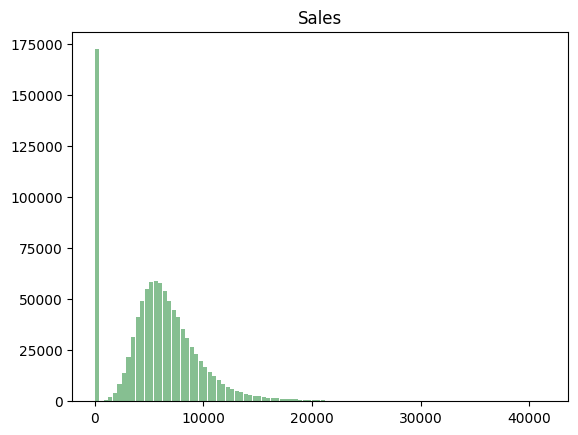

In [19]:
merged_train_df.hist(column='Sales', bins=100, grid=False, color='#86bf91', zorder=2, rwidth=0.9)
plt.show()

We notice that there are many small values, maybe they are just 0 sales for when the store is closed!

In [20]:
indices_closed_0sales = merged_train_df.query('Open == "0" and Sales == 0').index
indices_0sales = merged_train_df.query('Sales == 0').index
indices_closed = merged_train_df.query('Open == "0"').index
print('n_samples Days closed AND Sales=0: ',len(list(indices_closed_0sales)))
print('n_samples Sales=0: ', len(list(indices_0sales)))
print('n_samples Open=0: ', len(list(indices_closed)))
print('Identical' if list(indices_closed) == list(indices_closed_0sales) else "Not Identical")


n_samples Days closed AND Sales=0:  172361
n_samples Sales=0:  172415
n_samples Open=0:  172361
Identical


Since indices_closed == indices_closed_0sales, we see that nearly all the samples with 0 sales are ones where the stores are simply closed with Open=0

Therefore, we remove the rows with Open=0 and remove the column (open) as it is not interesting

In [21]:
merged_train_df.drop(indices_closed_0sales ,inplace=True)
merged_train_df.drop('Open', axis=1 ,inplace=True)

 with the histogram below we can see that:
1. The peak at 0 is gone.
2. The distribution of Sales data is !close! to being normal / Gaussian which may allow the use ANOVA (which requires normality) without worrying about violating this assumption

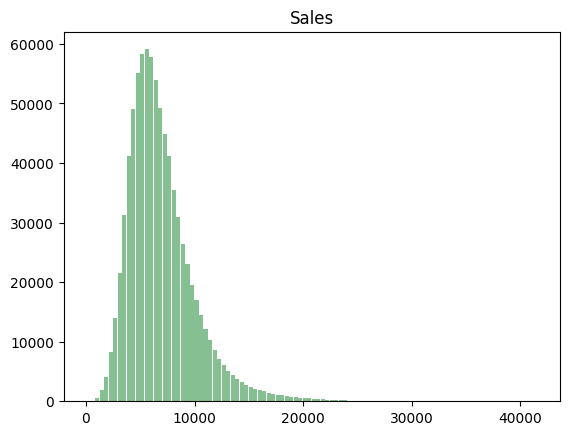

In [22]:
merged_train_df.hist(column='Sales', bins=100, grid=False, color='#86bf91', zorder=2, rwidth=0.9)
plt.show()

Next, we explore the relation between our target variable (Sales) and some of the categorical features namely, (DayOfWeek, MonthOfYear, Assortment, StoreType)

In [23]:
merged_train_df = merged_train_df.astype({'Store': 'str', 'DayOfWeek': 'str',
                                         'Sales': 'float', 'Promo': 'str',
                                         'StateHoliday': 'str', 'SchoolHoliday': 'str',
                                         'PromoInterval': 'str'})
display(merged_train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 842206 entries, 0 to 1017190
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Store                842206 non-null  object 
 1   DayOfWeek            842206 non-null  object 
 2   MonthOfYear          842206 non-null  object 
 3   Sales                842206 non-null  float64
 4   Promo                842206 non-null  object 
 5   StateHoliday         842206 non-null  object 
 6   SchoolHoliday        842206 non-null  object 
 7   StoreType            842206 non-null  object 
 8   Assortment           842206 non-null  object 
 9   CompetitionDistance  842206 non-null  float64
 10  Promo2ForDays        842206 non-null  float64
 11  PromoInterval        842206 non-null  object 
dtypes: float64(3), object(9)
memory usage: 83.5+ MB


None

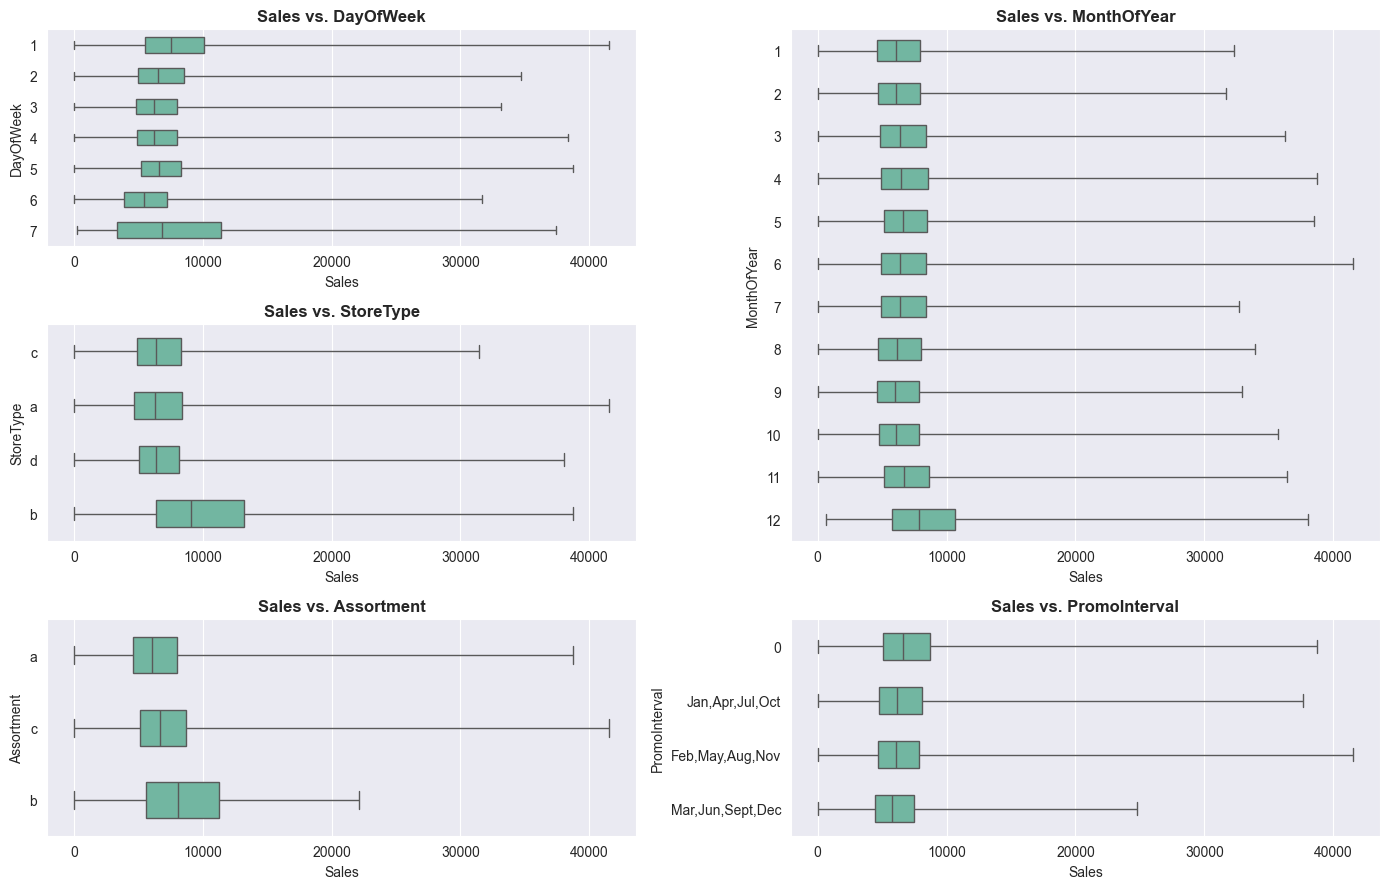

In [24]:
sns.set_style('darkgrid')
sns.set_palette('Set2')

figure_1 = plt.figure(figsize=(14, 9))
gs = figure_1.add_gridspec(3, 2)

ax_dayofweek = figure_1.add_subplot(gs[0, 0])
sns.boxplot(y='DayOfWeek',
            x="Sales",
            data=merged_train_df,
            order=[str(i + 1) for i in range(7)],
            ax=ax_dayofweek,
            whis=(0, 100),
            width=0.5)
ax_dayofweek.set_title("Sales vs. DayOfWeek", fontweight='bold')

ax_storetype = figure_1.add_subplot(gs[1, 0])
sns.boxplot(y='StoreType',
            x="Sales",
            data=merged_train_df,
            ax=ax_storetype,
            whis=(0, 100),
            width=0.5)
ax_storetype.set_title("Sales vs. StoreType", fontweight='bold')

ax_assortment = figure_1.add_subplot(gs[2, 0])
sns.boxplot(y='Assortment',
            x="Sales",
            data=merged_train_df,
            ax=ax_assortment,
            whis=(0, 100),
            width=0.5)
ax_assortment.set_title("Sales vs. Assortment", fontweight='bold')

ax_promo = figure_1.add_subplot(gs[2, 1])
sns.boxplot(y='PromoInterval',
            x="Sales",
            data=merged_train_df,
            ax=ax_promo,
            whis=(0, 100),
            width=0.5)
ax_promo.set_title("Sales vs. PromoInterval", fontweight='bold')

ax_monthofyear = figure_1.add_subplot(gs[:2, 1])
sns.boxplot(y='MonthOfYear',
            x="Sales",
            data=merged_train_df,
            order=[str(i + 1) for i in range(12)],
            ax=ax_monthofyear,
            whis=(0, 100),
            width=0.5)
ax_monthofyear.set_title("Sales vs. MonthOfYear", fontweight='bold')

plt.tight_layout()
plt.show()

We can see that in the features (DayOfWeek, MonthOfYear, Assortment, StoreType) at least one label in each of these features deviates in its range of values in Sales which means that these features will all be useful. However, PromoInterval offers no predictive power and so it is removed.

In [25]:
merged_train_df.drop('PromoInterval', axis=1, inplace=True)

Next, we look into the relation between Sales and the features: (promo, SchoolHoliday, StateHoliday)

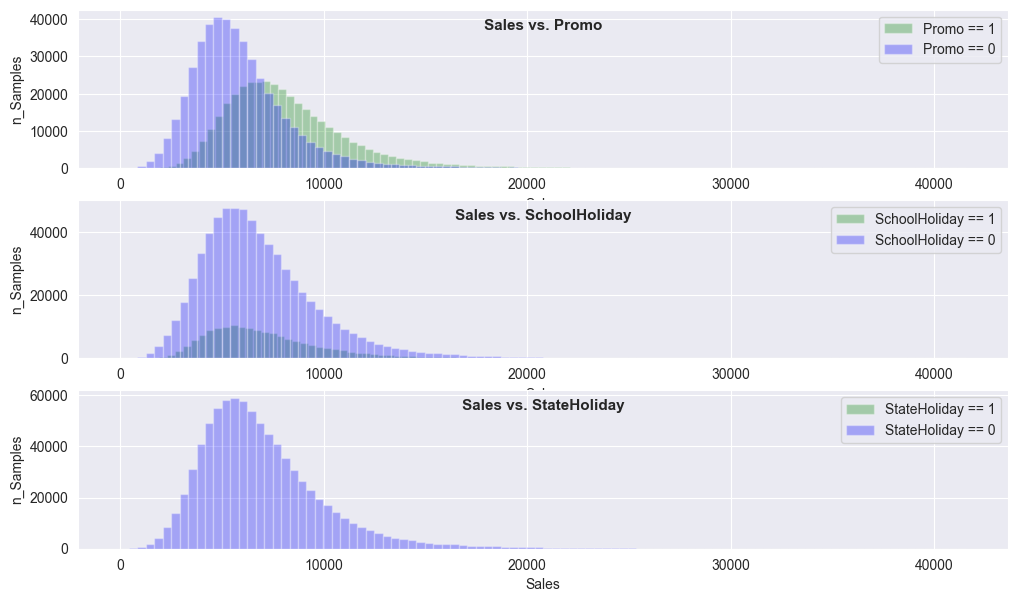

In [26]:
figure_2, axis_2 = plt.subplots(nrows=3,
                                ncols=1,
                                figsize=(12,7))
axis_2[0].hist(merged_train_df[merged_train_df["Promo"] == "1"]["Sales"],
            bins=100,
            alpha=0.3,
            color="green",
            label="Promo == 1")
axis_2[0].hist(merged_train_df[merged_train_df["Promo"] == "0"]["Sales"],
            bins=100,
            alpha=0.3,
            color="blue",
            label="Promo == 0")
axis_2[0].set_xlabel("Sales")
axis_2[0].set_ylabel("n_Samples")
axis_2[0].text(0.5, 0.9, "Sales vs. Promo",
                ha='center', va='center',
                transform=axis_2[0].transAxes,
                fontsize=11, fontweight='bold')
axis_2[0].legend()

axis_2[1].hist(merged_train_df[merged_train_df["SchoolHoliday"] == "1"]["Sales"],
                bins=100,
                alpha=0.3,
                color="green",
                label="SchoolHoliday == 1")
axis_2[1].hist(merged_train_df[merged_train_df["SchoolHoliday"] == "0"]["Sales"],
                bins=100,
                alpha=0.3,
                color="blue",
                label="SchoolHoliday == 0")
axis_2[1].set_xlabel("Sales")
axis_2[1].set_ylabel("n_Samples")
axis_2[1].text(0.5, 0.9, "Sales vs. SchoolHoliday",
                ha='center', va='center',
                transform=axis_2[1].transAxes,
                fontsize=11, fontweight='bold')
axis_2[1].legend()

axis_2[2].hist(merged_train_df[merged_train_df["StateHoliday"] == "1"]["Sales"],
                bins=100,
                alpha=0.3,
                color="green",
                label="StateHoliday == 1")
axis_2[2].hist(merged_train_df[merged_train_df["StateHoliday"] == "0"]["Sales"],
                bins=100,
                alpha=0.3,
                color="blue",
                label="StateHoliday == 0")
axis_2[2].set_xlabel("Sales")
axis_2[2].set_ylabel("n_Samples")
axis_2[2].text(0.5, 0.9, "Sales vs. StateHoliday",
                ha='center', va='center',
                transform=axis_2[2].transAxes,
                fontsize=11, fontweight='bold')
axis_2[2].legend()
plt.show()

Observations:
1. plt1, Knowing if there is a promotion clearly helps in making a prediction given the difference in distributions
2. plt2, There seems to be no predictive power in SchoolHoliday as the distribution is almost the same
whether there is a SchoolHoliday or not apart from the ability to indicate the potential presence of outliers.
3. plt3, We can see that having a StateHoliday only has samples with StateHoliday == 0, this could be that the store always closes when there is a StateHoliday (StateHoliday==1), and because we have removed all the samples with Open==0, then what we have left are the samples only with StateHoliday==0

Decisions:
1. Remove the columns SchoolHoliday and StateHoliday

In [27]:
merged_train_df.drop(['StateHoliday', 'SchoolHoliday'], axis=1, inplace=True)

Next, we look into scatter plots between Sales and (Promo2ForDays CompetitionDistance)

C:\Users\Doppler\.virtualenvs\ML_SalesRegression-VwW4zbpJ\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


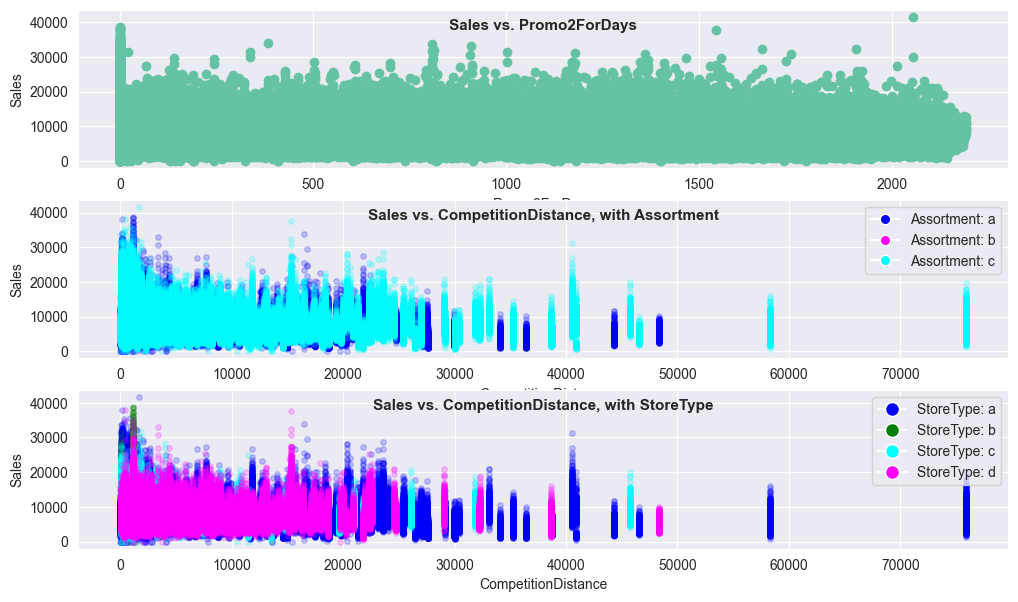

In [28]:
figure_3, axis_3 = plt.subplots(nrows=3,
                                ncols=1,
                                figsize=(12, 7))
axis_3[0].scatter(merged_train_df["Promo2ForDays"],merged_train_df["Sales"])
axis_3[0].set_xlabel("Promo2ForDays")
axis_3[0].set_ylabel("Sales")
axis_3[0].text(0.5, 0.9, "Sales vs. Promo2ForDays",
                ha='center', va='center',
                transform=axis_3[0].transAxes,
                fontsize=11, fontweight='bold')

axis_3[1].scatter(merged_train_df[merged_train_df["Assortment"] == "a"]["CompetitionDistance"],
                  merged_train_df[merged_train_df["Assortment"] == "a"]["Sales"],
                  c="blue",
                  alpha=0.2,
                  s=15,
                  marker='o')

axis_3[1].scatter(merged_train_df[merged_train_df["Assortment"] == "b"]["CompetitionDistance"],
                  merged_train_df[merged_train_df["Assortment"] == "b"]["Sales"],
                  c="magenta",
                  alpha=0.2,
                  s=15,
                  marker='o')

axis_3[1].scatter(merged_train_df[merged_train_df["Assortment"] == "c"]["CompetitionDistance"],
                  merged_train_df[merged_train_df["Assortment"] == "c"]["Sales"],
                  c="cyan",
                  alpha=0.2,
                  s=15,
                  marker='o')

axis_3[1].set_xlabel("CompetitionDistance")
axis_3[1].set_ylabel("Sales")

color_patches = [
    matplotlib.lines.Line2D([0], [0], marker='.', color='w', label='Assortment: a', markerfacecolor='blue', markersize=15),
    matplotlib.lines.Line2D([0], [0], marker='.', color='w', label='Assortment: b', markerfacecolor='magenta', markersize=15),
    matplotlib.lines.Line2D([0], [0], marker='.', color='w', label='Assortment: c', markerfacecolor='cyan', markersize=15)
]

axis_3[1].legend(handles=color_patches)

axis_3[1].text(0.5, 0.9, "Sales vs. CompetitionDistance, with Assortment",
                ha='center', va='center',
                transform=axis_3[1].transAxes,
                fontsize=11, fontweight='bold')

axis_3[2].scatter(merged_train_df[merged_train_df["StoreType"] == "a"]["CompetitionDistance"],
                  merged_train_df[merged_train_df["StoreType"] == "a"]["Sales"],
                  c="blue",
                  alpha=0.2,
                  s=15,
                  marker='o')

axis_3[2].scatter(merged_train_df[merged_train_df["StoreType"] == "b"]["CompetitionDistance"],
                  merged_train_df[merged_train_df["StoreType"] == "b"]["Sales"],
                  c="green",
                  alpha=0.2,
                  s=15,
                  marker='o')

axis_3[2].scatter(merged_train_df[merged_train_df["StoreType"] == "c"]["CompetitionDistance"],
                  merged_train_df[merged_train_df["StoreType"] == "c"]["Sales"],
                  c="cyan",
                  alpha=0.2,
                  s=15,
                  marker='o')

axis_3[2].scatter(merged_train_df[merged_train_df["StoreType"] == "d"]["CompetitionDistance"],
                  merged_train_df[merged_train_df["StoreType"] == "d"]["Sales"],
                  c="magenta",
                  alpha=0.2,
                  s=15,
                  marker='o')

axis_3[2].set_xlabel("CompetitionDistance")
axis_3[2].set_ylabel("Sales")

color_patches = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='StoreType: a', markerfacecolor='blue', markersize=10),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='StoreType: b', markerfacecolor='green', markersize=10),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='StoreType: c', markerfacecolor='cyan', markersize=10),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='StoreType: d', markerfacecolor='magenta', markersize=10)
]

axis_3[2].legend(handles=color_patches)
axis_3[2].text(0.5, 0.9, "Sales vs. CompetitionDistance, with StoreType",
                ha='center', va='center',
                transform=axis_3[2].transAxes,
                fontsize=11, fontweight='bold')
plt.show()

Observations:
1. plot1- There seems to be no correlation between Promo2ForDays and Sales
2. plot2- and plot_3- There seems to be a negative correlation as the greater CompetitionDistance is, the lower the Sales

Decisions:
1. We consider Dropping the column Promo2ForDays, but wait to see the heatmap of correlations later on...

**Side note**: it is interesting to see how certain Assortment and/or StoreTypes exist depending on CompetitionDistance

# Part 3 - Statistical EDA


After the visual exploratory data analysis (EDA), we conduct a brief statistical EDA where we (a) look into a correlation heatmap between the numeric features and (b) implement ANOVA which tells us if "Store" feature is relevant for predicting the Sales.

This is because we could not have visually explored the relation between Store and Sales given the great
number of labels in Store with about 1115 labels

Start by looking into correlation between Sales and  (Promo2ForDays CompetitionDistance)

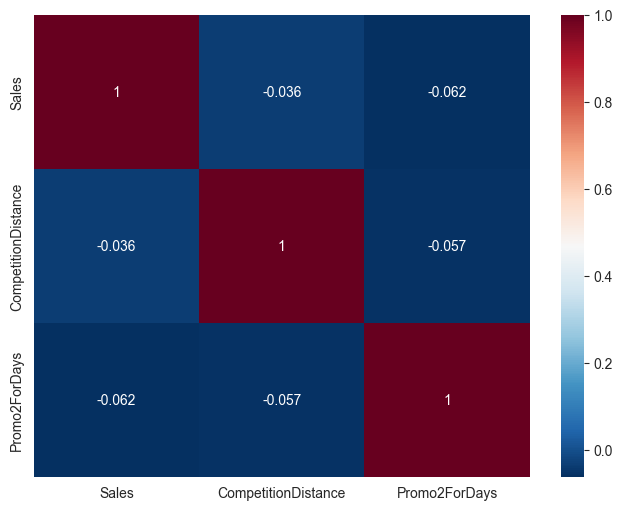

In [29]:
numeric_df = merged_train_df[['Sales', 'CompetitionDistance', 'Promo2ForDays']]
numeric_correlations = numeric_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_correlations, cmap='RdBu_r', annot=True)
plt.show()

Observations:
* The correlation is weak between Sales and (CompetitionDistance, Promo2ForDays),  
       
Decisions:
* We remove only Promo2ForDays, when it comes to CompetitionDistance, we keep it since as we saw earlier in visual_eda CompetitionDistance relates to Assortment and StorType which correlate with Sales, so the correlation
between CompetitionDistance and Sales is indirect and is not visible using a simple correlation measure.

In [30]:
merged_train_df.drop('Promo2ForDays', axis=1, inplace=True)

Now we implement **ANOVA** which is the alternative to a the boxplot we had earlier for features with many labels like Store with about 1115 labels. ANOVA tells us if the feature (Store) has any predictive value for Sales

In [31]:
store_sales_list = [list(merged_train_df.loc[merged_train_df["Store"] == label, "Sales"])
                    for label in set(merged_train_df['Store'])]
F, p = f_oneway(*store_sales_list)
display(F, p)

np.float64(1144.0522315545602)

np.float64(0.0)

the result is F = 1144 and p=0.0 which means that there is at least one label whose Sales distribution
deviates from the other labels' distributions which means that we can keep Store column since it has good predictive power.

Because Store has 1115 labels, we have to perform some compression. Something as simple one-hot encoding would make the samples very sparse in the feature space causing difficulties in learning and prediction.

Embedding could be used but is not reasonable in this application as it is usually used in the context of NLP  and neither is regularization as it is used to tune down features of less importance.

We choose to handle this intuitively, the Store label is used to give an idea over possible Sales range, therefore, we divide the Sales dimension into n bins, where each bin is a new label of Store, then for each
Store (1, 2, 3...) we calculate the median of its sales and check under which bin it falls, then  give it a new label following bin (say Store number 27 --> bin number 1). This guides the possible Sales value

In [32]:
# Median Sales of each label
median_sales_per_label = merged_train_df.groupby('Store')['Sales'].median()
#median_sales_per_label.hist(bins=15, grid=False, color='#86bf91', zorder=2, rwidth=0.9)
# divide Store into bins
binned_medians = pd.cut(median_sales_per_label, bins=20, labels=range(20))
# Map original Store number into corresponding bin
merged_train_df[f"{'Store'}_compressed"] = merged_train_df['Store'].map(binned_medians)
merged_train_df.drop('Store', axis=1, inplace=True)

# Part 4 - Deep Neural Network (DNN)

Before implementing the DNN, we first **split** into **training** and **validation** sets and **normalize** numeric inputs.

Since we have alot of data (842206 samples) we limit the size of the validation set to just 5% of the available samples.

We also perform **normalization** so that all the samples are expressed in terms of their z-score, this ought to accelerate learning while not emphasizing any feature over the others.

In [33]:
numeric_col_names = ['CompetitionDistance']
df_train, df_valid = sklearn.model_selection.train_test_split(merged_train_df, train_size=0.95, random_state=1)
train_stats = df_train.describe().transpose()
df_train_norm, df_valid_norm = df_train.copy(), df_valid.copy()
for col_name in numeric_col_names:
    mean = train_stats.loc[col_name, 'mean']
    std = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean) / std
    df_valid_norm.loc[:, col_name] = (df_valid_norm.loc[:, col_name] - mean) / std

x_train = torch.tensor(df_train_norm[numeric_col_names].values)
x_valid = torch.tensor(df_valid_norm[numeric_col_names].values)

We also one-hot encode all categorical features

In [34]:
nominal_col_names = ['Assortment', 'StoreType',
                          'Promo', 'MonthOfYear',
                          'DayOfWeek', 'Store_compressed']
for col_name in nominal_col_names:
    unique, inverse = np.unique(df_train_norm[col_name].values, return_inverse=True)
    encoded_col = torch.from_numpy(np.eye(unique.shape[0])[inverse])
    x_train = torch.cat([x_train, encoded_col], 1).float()

    unique, inverse = np.unique(df_valid_norm[col_name].values, return_inverse=True)
    encoded_col = torch.from_numpy(np.eye(unique.shape[0])[inverse])
    x_valid = torch.cat([x_valid, encoded_col], 1).float()

y_train = torch.tensor(df_train_norm['Sales'].values).float()
y_valid = torch.tensor(df_valid_norm['Sales'].values).float()

## Defining the DNN
Now we are ready to implement the DNN, after some testing, we define it with two hidden layers with the first having 30 neurons while the second having 10 neurons

In [35]:
class DNN(nn.Module) :
    def __init__(self) -> None:
        super().__init__()
        l1 = nn.Linear(49, 30)
        a1 = nn.ReLU()
        l2 = nn.Linear(30, 10)
        a2 = nn.ReLU()
        l3 = nn.Linear(10, 1)
        a3 = nn.ReLU()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

        # Initialization:
        # kaiming normal best suited given ReLU activation
        #Source: https://doi.org/10.48550/arXiv.1502.01852
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight,
                                              mode='fan_in',
                                              nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()


    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

And now we train the network on our data. But first we define the function used to measure the performance of the network, room mean square percentage error (RMSPE). RMSPE is only used for us to have an intuition over performance improvement, when it comes to the loss function however, MSE is sued. 

In [36]:
def rmspe_loss_fn(prediction, target):
    mask = target != 0
    prediction = prediction[mask]
    target = target[mask]
    loss = torch.sqrt(torch.mean(((target - prediction) / target) ** 2))
    return loss

Epoch 0 - MSE Train Loss:17688996.0270      MSE Valid Loss:4315475.3602      RMSPE Valid Loss:0.3249
Epoch 1 - MSE Train Loss:3369133.1738      MSE Valid Loss:2708867.8309      RMSPE Valid Loss:0.2638
Epoch 2 - MSE Train Loss:2517472.9535      MSE Valid Loss:2237692.9521      RMSPE Valid Loss:0.2511
Epoch 3 - MSE Train Loss:2187120.1877      MSE Valid Loss:2021712.5080      RMSPE Valid Loss:0.2448
Epoch 4 - MSE Train Loss:2025384.7270      MSE Valid Loss:1923609.4293      RMSPE Valid Loss:0.2378
Epoch 5 - MSE Train Loss:1950845.6097      MSE Valid Loss:1877893.9100      RMSPE Valid Loss:0.2395
Epoch 6 - MSE Train Loss:1918429.9718      MSE Valid Loss:1858129.5695      RMSPE Valid Loss:0.2412
Epoch 7 - MSE Train Loss:1902497.5508      MSE Valid Loss:1847021.1831      RMSPE Valid Loss:0.2376


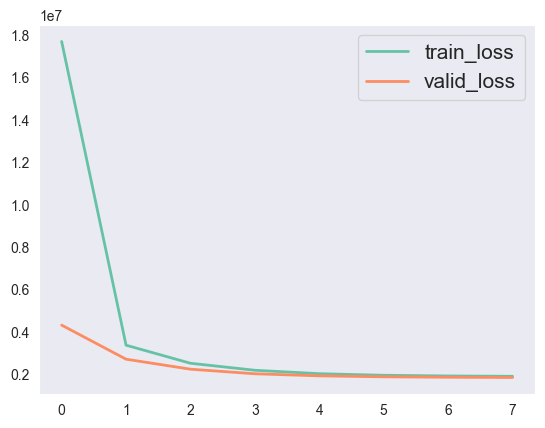

In [37]:
#DataLoader
train_ds = TensorDataset(x_train, y_train)
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
#Model, architecture, loss, optimizer
model = DNN()
MSE_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.5e-3)
num_epochs = 8
MSE_loss_hist_train = [0] * num_epochs

if x_valid is not None: # if we want to train DNN on all data
    torch.manual_seed(1)
    valid_ds = TensorDataset(x_valid, y_valid)
    MSE_loss_hist_valid = [0] * num_epochs
    RMSPE_loss_hist_valid = [0] * num_epochs
    valid_dl = DataLoader(valid_ds, batch_size, shuffle=False)


for epoch in range(num_epochs):
    model.train()  # Set to training mode
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        MSE_loss = MSE_loss_fn(pred, y_batch)
        MSE_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        MSE_loss_hist_train[epoch] += MSE_loss.item()
    MSE_loss_hist_train[epoch] /= len(train_dl)

    model.eval() # Set to evaluation mode
    with torch.no_grad():
        for x_batch, y_batch in valid_dl:
            pred = model(x_batch)[:, 0]
            MSE_loss_hist_valid[epoch] += MSE_loss_fn(pred, y_batch).item()
            RMSPE_loss_hist_valid[epoch] += rmspe_loss_fn(pred, y_batch).item()

            # Average validation losses over batches
        MSE_loss_hist_valid[epoch] /= len(valid_dl)
        RMSPE_loss_hist_valid[epoch] /= len(valid_dl)

        print(f'Epoch {epoch} - MSE Train Loss:{MSE_loss_hist_train[epoch]:.4f}'
              f'      MSE Valid Loss:{MSE_loss_hist_valid[epoch]:.4f}'
              f'      RMSPE Valid Loss:{RMSPE_loss_hist_valid[epoch]:.4f}')


plt.plot([i for i in range(num_epochs)],MSE_loss_hist_train, lw=2)
plt.plot([i for i in range(num_epochs)],MSE_loss_hist_valid, lw=2)
plt.legend(['train_loss', 'valid_loss'], fontsize = 15)
plt.grid()
plt.show()

# Part 5 - Regression Forest

Implementing the RegressionForest, we first split into training and validation sets. Since we have alot of data (842206 samples) we limit the size of the validation set to just 5% of the available samples.

In [38]:
def one_hot_encode(df : pd.DataFrame, categorical_columns : list[str]) -> pd.DataFrame:
    """
        Performs one-hot encoding on specified categorical columns in the DataFrame.
    """
    one_hot_encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
    for col_name in categorical_columns:
        encoded_col_df = one_hot_encoder.fit_transform(df[col_name].to_frame())
        df = pd.concat([df, encoded_col_df], axis=1).drop(columns=[col_name])
    return df

input_col_names = ['CompetitionDistance', 'Assortment', 'StoreType',
                      'Promo', 'MonthOfYear',
                      'DayOfWeek', 'Store_compressed']

categorical_col_names= ['Assortment', 'StoreType',
                      'Promo', 'MonthOfYear',
                      'DayOfWeek', 'Store_compressed']
df_train, df_valid = sklearn.model_selection.train_test_split(merged_train_df, train_size=0.95, random_state=1)

x_train = df_train[input_col_names]
y_train = df_train['Sales']

x_valid = df_valid[input_col_names]
y_valid = df_valid['Sales']

x_train = one_hot_encode(x_train, categorical_col_names)
x_valid = one_hot_encode(x_valid, categorical_col_names)

We also define loss functions mean square error (MSE) to compare the performance of the regression tree to the DNN

In [39]:
def rmspe_loss_fn(prediction, target):
    mask = target != 0
    prediction = prediction[mask]
    target = target[mask]
    loss = np.sqrt(np.mean(((target - prediction) / target) ** 2))
    return loss

def mse_loss_fn(prediction, target):
    mask = target != 0
    prediction = prediction[mask]
    target = target[mask]
    loss = np.mean((target - prediction) ** 2)
    return loss

Lastly, we implement and train the regression forest

In [40]:
x_train = x_train.values
y_train =  y_train.values

x_valid = x_valid.values
y_valid = y_valid.values
rng = np.random.RandomState(1)


regression_forest = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=22), n_estimators=10, random_state=rng #depth ref  22, n_estimators ref 10
)
regression_forest.fit(x_train, y_train)
valid_pred = regression_forest.predict(x_valid)
MSE_loss_valid = mse_loss_fn(valid_pred, y_valid)
RMSPE_loss_valid = rmspe_loss_fn(valid_pred, y_valid)
print(f'Depth:{22:.4f}    -  n_estimators:{10:.4f}      - MSE Valid Loss:{MSE_loss_valid:.4f}'
      f'      RMSPE Valid Loss:{RMSPE_loss_valid:.4f}')

Depth:22.0000    -  n_estimators:10.0000      - MSE Valid Loss:1356347.9252      RMSPE Valid Loss:0.1765
